# Chebyshev Derivatives with DCT Variants

Based on my [experiments with the various DCT types](https://github.com/pavelkomarov/spectral-derivatives/blob/main/notebooks/dct_types_comparison.ipynb) it seems like the DCT-II/III pair can better reconstruct a function with [fewer coefficients](https://dsp.stackexchange.com/questions/96172/why-does-the-dct-ii-have-better-energy-compaction-than-dct-i), which may be why it's the default DCT and the one used in commonplace compression algorithms.

It's natural to then wonder whether we could better represent functions with this other set of cosines and take derivatives with improved fidelity, even though it's not the variant that falls out of [the math](https://pavelkomarov.com/spectral-derivatives/math.pdf). So I've spent a while trying to [work it out](https://github.com/pavelkomarov/spectral-derivatives/issues/13).

In [1]:
import numpy as np
from scipy.fft import dct, dst
from matplotlib import pyplot

## A Minimal Example

Let's avert the need for the variable transfrom from $\theta$ to $x$ and simply work in the $\theta$ domain. The DCT is equivalent to a DFT on an O(half)-length vector (I say O as in order, because the exact value of $M$ varies type-to-type), so we only need to worry about the domain $\theta \in [0, \pi]$.

In [2]:
N = 7
th = np.linspace(0, np.pi, 100)

We'll define a function that's *even* on $[0, 2\pi)$, so we can take its 1st derivative (the simplest choice), which will be *odd* on the same interval.

In [3]:
y = lambda th: np.cos(3*th) + 3*np.cos(5 *th) # even function, only cosines so the DCT can truly capture it
dy = lambda th: -3*np.sin(3*th) - 15*np.sin(5*th) # odd function, analytic, known derivative

## DCT-I/DST-I

To ground ourselves in what we know works, let's do the type I case.

$$
\begin{align}
y_n &= \frac{1}{M} \Big( \underbrace{Y_0 + Y_N (-1)^n + 2 \sum_{k=1}^{N-1} Y_k \cos(\frac{\pi nk}{N})}_{\text{DCT-I}} \Big) \\
y_n^{(\text{odd } \nu)} &= \frac{1}{M} \underbrace{2 \sum_{k=1}^{N-1} j (jk)^\nu Y_k \sin(\frac{\pi nk}{N})}_{\text{DST-I}} \\
y_n^{(\text{even } \nu)} &= \frac{1}{M} \Big( \underbrace{(j0)^\nu Y_0 + (jN)^\nu Y_N (-1)^n + 2 \sum_{k=1}^{N-1} (jk)^\nu Y_k \cos(\frac{\pi nk}{N})}_{\text{DCT-I}} \Big)
\end{align}
$$

Notice we're sampling at:

$$\theta_{n1} = \frac{\pi}{N}n$$

And the implicit vector underlying a DFT equivalent to type-I has indices:

$$[0, 1, ... N-1, N, -(N-1), ... -1]$$

which has length $M = 2N$.

L1: 3.552713678800501e-15


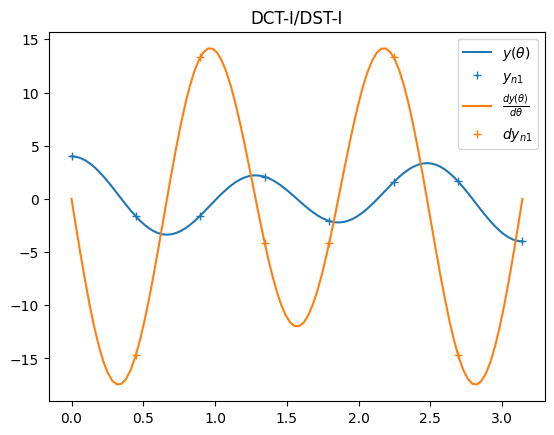

In [4]:
M = 2*N
k = np.arange(N+1); k[-1] = 0 # We zero out the Nyquist term, M/2 = N, corresponding to Y_N

th_n1 = np.linspace(0, np.pi, N+1, endpoint=True) # INCLUDE the endpoint, because [0, ... N]

y_n1 = y(th_n1)
Y_k = dct(y_n1, 1)
Y_p = -k * Y_k # j * (jk) * Y_k
dy_n1 = dst(Y_p[1:-1], 1)/M # The DST-I definition takes only the central (nonzero) part of Y_p

print("L1:", np.max(np.abs(dy_n1 - dy(th_n1)[1:-1]))) # compare against analytic answer

pyplot.plot(th, y(th), label=r"$y(\theta)$")
pyplot.plot(th_n1, y_n1, 'C0+', label=r"$y_{n1}$")
pyplot.plot(th, dy(th), label=r"$\frac{dy(\theta)}{d\theta}$")
pyplot.plot(th_n1[1:-1], dy_n1, 'C1+', label=r"$dy_{n1}$")
pyplot.title("DCT-I/DST-I")
pyplot.legend()
pyplot.show()

The numerically-found derivative matches the analytic truth *perfectly*, and the answes still fall on the $\theta_{n1}$ samples, but the endpoints are missing. This turns out to not be such a problem, though, because we have to find domain endpoints by [L'Hôpital's rule anyway](https://github.com/pavelkomarov/spectral-derivatives/blob/main/notebooks/chebyshev_domain_endpoints.ipynb).

## DCT-II/DST-III

Now let's transform to frequency domain with type II, which assumes the data is coming [from half-index points](https://github.com/pavelkomarov/spectral-derivatives/issues/13) and transforms on to whole-number index points, and try to come back with the natural inverse, a type III, which assumes we're going from whole number index points to half-index points.

$$
\begin{align}
Y_k &= \underbrace{2 \sum_{n=0}^N y_n \cos\Big(\frac{\pi k}{N + 1}(n + \frac{1}{2})\Big)}_{\text{DCT-II}}\\
y_n & = \frac{1}{M} \Big( \underbrace{Y_0 + 2 \sum_{k=1}^N Y_k \cos\Big(\frac{\pi k}{N + 1}(n + \frac{1}{2})\Big)}_{\text{DCT-III}} \Big)\\
y_n^{(\text{odd } \nu)} &= \frac{1}{M} \Big( \underbrace{(-1)^n Y_N + 2 \sum_{k=1}^{N-1} Y_k \sin\Big(\frac{\pi k}{N}(n + \frac{1}{2})\Big)}_{\text{DST-III}} \Big)\\
y_n^{(\text{even } \nu)} &= \frac{1}{M} \Big( \underbrace{Y_0 + 2 \sum_{k=1}^N Y_k \cos\Big(\frac{\pi k}{N + 1}(n + \frac{1}{2})\Big)}_{\text{DCT-III}} \Big)
\end{align}
$$

This is a bit strange to contemplate, but 

L1: 1.4210854715202004e-14


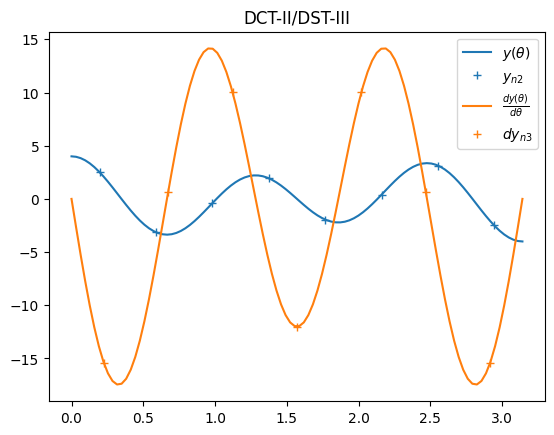

In [5]:
M = 2*(N+1)
k = np.arange(N+1) # Here the M/2th term = (N+1)th, and the DST-III nor DCT-III reconstructions have a Y_{N+1}, so the Nyquist term is already zeroed.

# At n = 0 we're already at 1/2 a step
th_n2 = np.pi/(N+1) * (np.arange(N+1) + 0.5) # sample from half-indices
th_n3 = np.pi/N * (np.arange(N) + 0.5) # We get a shorter thing back!

y_n2 = y(th_n2)
Y_k = dct(y_n2, 2) # The DCT-II assumes our samples are from half-indices (th_n2)
Y_p = -k * Y_k # j * (jk) * Y_k
dy_n3 = dst(Y_p[1:], 3)/M # The DST-III definition takes only the latter (nonzero) part of Y_k

print("L1:", np.max(np.abs(dy_n3 - dy(th_n3))))

pyplot.plot(th, y(th), label=r"$y(\theta)$")
pyplot.plot(th_n2, y_n2, 'C0+', label=r"$y_{n2}$")
pyplot.plot(th, dy(th), label=r"$\frac{dy(\theta)}{d\theta}$")
pyplot.plot(th_n3, dy_n3, 'C1+', label=r"$dy_{n3}$")
pyplot.title("DCT-II/DST-III")
pyplot.legend()
pyplot.show()

So we can get a perfect match, but we've used some slightly strange samples here. Notice the samples of the original function and the derivative don't align!

## Visualizing the Different $\theta$

The above has used several different samplings of $\theta$, which are helpful to look at visually.

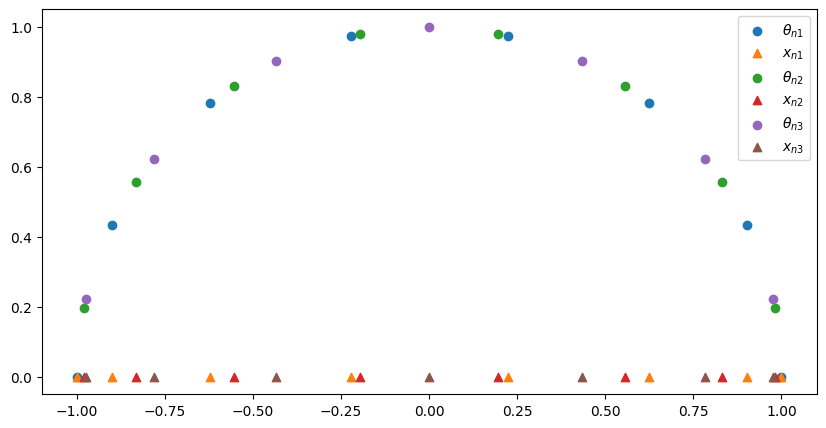

In [6]:
pyplot.figure(figsize=(10,5))
pyplot.scatter(np.cos(th_n1), np.sin(th_n1), label=r"$\theta_{n1}$")
pyplot.scatter(np.cos(th_n1), [0 for i in range(len(th_n1))], label=r"$x_{n1}$", marker='^')
pyplot.scatter(np.cos(th_n2), np.sin(th_n2), label=r"$\theta_{n2}$")
pyplot.scatter(np.cos(th_n2), [0 for i in range(len(th_n2))], label=r"$x_{n2}$", marker='^')
pyplot.scatter(np.cos(th_n3), np.sin(th_n3), label=r"$\theta_{n3}$")
pyplot.scatter(np.cos(th_n3), [0 for i in range(len(th_n3))], label=r"$x_{n3}$", marker='^')
pyplot.legend()
pyplot.show()

The DCT-I/DST-I uses the 1 sampling; the DCT-II uses the 2 sampling, and the DST-III uses the 3 sampling.

This is *weird*. It's unclear whether we actually want to use a reconstruction that occurs at a different sampling. Moreover, the 2 and 3 samplings *don't go all the way to the edges of the domain*, and they fail to make it to the edge by *different amounts*. Given we probably want to impose boundary conditions, having a sampling that doesn't include the boundary is probably bad news.

Can we make some modification to the above to get the samplings to fall on the original 1 sampling? Unclear. If there is a way, it probably has to do with the [phase ramping](https://github.com/pavelkomarov/spectral-derivatives/blob/main/notebooks/dft_dct_dst_relationship.ipynb) and would likely come out somewhat messy. The cleanest thing to do is accept the the type 1 transforms, which are [theoretically motivated anyway](https://pavelkomarov.com/spectral-derivatives/math.pdf).